# USDA Soil Texture Profile by Depth (Matplotlib) — Robust Version

You noticed two symptoms:
1) the figure can become **extremely tall**  
2) the plot can look **blank after the first layer**

This notebook adds **diagnostics + safe sizing** so you can quickly see what's going on.

## Why this happens
- **Figure size is in inches.** If you (even accidentally) set figure height using depth values (e.g., 300), you get a **300‑inch** figure → huge/blank output.
- If your depth columns contain non-numeric text, rows may get dropped → only the first layer remains.

## Expected Excel columns (case-insensitive)
- `Sample`
- `Texture`
- `Top_ft`, `Bottom_ft`
- `Top_cm`, `Bottom_cm`


In [41]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Patch

DATA_DIR = "/workspaces/hwrs564b_course_materials_JessicaCarvalho007/Homework/4_Measurements/USDA Soil Texture"

# List Excel files available
sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith((".xlsx", ".xls"))])


['Sample 1.1 textures.xlsx',
 'Sample 1.1.xlsx',
 'Sample 2.1 textures.xlsx',
 'Sample 2.1.xlsx',
 'Sample 2.2.xlsx',
 'my_soils.xlsx']

## 1) Choose the file and plot settings

In [42]:
# ---- Choose ONE file at a time ----
EXCEL_PATH = os.path.join(DATA_DIR, "Sample 1.1 textures.xlsx")  # <-- change this each run

# ---- Choose units for plotting ----
DEPTH_UNITS = "ft"  # "cm" or "ft"

# ---- Fill mode ----
FILL_MODE = "hatch"  # "hatch" or "png"

# ---- PNG options (only used if FILL_MODE="png") ----
PNG_DIR = os.path.join(DATA_DIR, "texture_png")
MAKE_PNGS_IF_MISSING = True

# ---- Figure options ----
# IMPORTANT: figsize is inches. Keep it reasonable.
FIGWIDTH_IN = 3.2

AUTO_FIGHEIGHT = True
INCHES_PER_100_CM = 1.8   # controls how tall the plot is for cm units
INCHES_PER_10_FT  = 1.8   # controls how tall the plot is for ft units
FIGHEIGHT_MIN_IN  = 4.5
FIGHEIGHT_MAX_IN  = 10.0

DPI = 150
TITLE = "Pit 1 - Texture by Depth"          # e.g., "Pit A - USDA Soil Texture by Depth"
LABEL_LAYERS = False
LEGEND = True

SAVE_FIG = False
OUT_PNG = os.path.join(DATA_DIR, "texture_profile.png")


## 2) Functions: load, normalize, diagnose, and plot

In [43]:
\
plt.rcParams["hatch.linewidth"] = 1.2  # make hatch more visible

TEXTURE_STYLE = {
    "Sand":            dict(facecolor="khaki",      hatch=".."),
    "Loamy Sand":      dict(facecolor="navajowhite", hatch="..//"),
    "Sandy Loam":      dict(facecolor="wheat",      hatch="//"),
    "Loam":            dict(facecolor="tan",        hatch="xx"),
    "Sandy Clay Loam": dict(facecolor="peru",       hatch="++"),
    "Sandy Clay":      dict(facecolor="chocolate",  hatch="\\\\"),
    "Clay":            dict(facecolor="sienna",     hatch="\\\\\\\\"),
}

_TEXTURE_ALIASES = {
    "sand": "Sand",
    "loamy sand": "Loamy Sand",
    "sandy loam": "Sandy Loam",
    "loam": "Loam",
    "sandy clay loam": "Sandy Clay Loam",
    "sandy clay": "Sandy Clay",
    "clay": "Clay",
}

AUTO_ADD_UNKNOWN_TEXTURES = True

def normalize_texture_label(x: str) -> str:
    if pd.isna(x):
        return ""
    s = str(x).strip().lower()
    s = re.sub(r"[_\-]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return _TEXTURE_ALIASES.get(s, s.title())

def ensure_texture_styles(textures, style_dict):
    textures = list(dict.fromkeys([str(t).strip() for t in textures if str(t).strip()]))
    missing = [t for t in textures if t not in style_dict]
    if not missing:
        return
    cmap = plt.cm.get_cmap("tab20")
    hatches = ["", "//", "\\\\", "..", "xx", "oo", "++", "--", "**", "||"]
    start = len(style_dict)
    for i, t in enumerate(missing):
        style_dict[t] = dict(facecolor=cmap((start + i) % cmap.N),
                             hatch=hatches[(start + i) % len(hatches)])
    print("Note: auto-added styles for unknown textures:", missing)

def _find_col(df, candidates):
    cols = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols:
            return cols[cand.lower()]
    return None

def load_texture_excel(excel_path: str, sheet_name=0) -> pd.DataFrame:
    raw = pd.read_excel(excel_path, sheet_name=sheet_name)
    if isinstance(raw, dict):
        first_sheet = next(iter(raw))
        print(f"Note: multiple sheets detected; using first sheet: {first_sheet!r}")
        df = raw[first_sheet]
    else:
        df = raw

    col_sample  = _find_col(df, ["Sample", "Layer", "Horizon", "ID"])
    col_texture = _find_col(df, ["Texture", "USDA_Texture", "Class"])
    col_top_ft    = _find_col(df, ["Top_ft", "Top (ft)"])
    col_bottom_ft = _find_col(df, ["Bottom_ft", "Bottom (ft)"])
    col_top_cm    = _find_col(df, ["Top_cm", "Top (cm)"])
    col_bottom_cm = _find_col(df, ["Bottom_cm", "Bottom (cm)"])

    required = [col_sample, col_texture, col_top_ft, col_bottom_ft, col_top_cm, col_bottom_cm]
    if any(c is None for c in required):
        raise ValueError(f"Missing required columns. Found: {list(df.columns)}")

    out = df[[col_sample, col_texture, col_top_ft, col_bottom_ft, col_top_cm, col_bottom_cm]].copy()
    out.columns = ["Sample", "Texture", "Top_ft", "Bottom_ft", "Top_cm", "Bottom_cm"]

    out["Sample"] = out["Sample"].astype(str).str.strip()
    out["Texture_raw"] = out["Texture"]
    out["Texture"] = out["Texture"].apply(normalize_texture_label)

    # Convert depth columns; keep a mask to report non-numeric rows
    depth_cols = ["Top_ft", "Bottom_ft", "Top_cm", "Bottom_cm"]
    numeric = out.copy()
    for c in depth_cols:
        numeric[c] = pd.to_numeric(numeric[c], errors="coerce")

    bad_depth = numeric[numeric[depth_cols].isna().any(axis=1)]
    if len(bad_depth) > 0:
        print("WARNING: Some rows have non-numeric depth values and will be dropped:")
        display(bad_depth[["Sample", "Texture_raw"] + depth_cols])

    out = numeric.dropna(subset=depth_cols).copy()
    out = out[out["Texture"].astype(str).str.len() > 0].copy()

    out = out.sort_values(["Top_cm", "Bottom_cm"]).reset_index(drop=True)

    bad = out[(out["Bottom_cm"] <= out["Top_cm"]) | (out["Bottom_ft"] <= out["Top_ft"])]
    if len(bad) > 0:
        raise ValueError("Found layers with Bottom <= Top. Check your depth columns.")

    if AUTO_ADD_UNKNOWN_TEXTURES:
        ensure_texture_styles(sorted(out["Texture"].unique()), TEXTURE_STYLE)

    return out

def recommend_figheight(df: pd.DataFrame, depth_units: str,
                        inches_per_100_cm=1.8, inches_per_10_ft=1.8,
                        min_in=4.5, max_in=10.0) -> float:
    top_col = "Top_cm" if depth_units == "cm" else "Top_ft"
    bot_col = "Bottom_cm" if depth_units == "cm" else "Bottom_ft"
    y_top = float(df[top_col].min())
    y_bot = float(df[bot_col].max())
    total = max(0.0, y_bot - y_top)

    if depth_units == "cm":
        h = (total / 100.0) * inches_per_100_cm
    else:
        h = (total / 10.0) * inches_per_10_ft

    return float(np.clip(h, min_in, max_in))

def validate_profile_continuity(df: pd.DataFrame, depth_units: str, tol=1e-6):
    top_col = "Top_cm" if depth_units == "cm" else "Top_ft"
    bot_col = "Bottom_cm" if depth_units == "cm" else "Bottom_ft"

    d = df.sort_values([top_col, bot_col]).reset_index(drop=True)
    gaps, overlaps = [], []
    for i in range(1, len(d)):
        prev_bot = float(d.loc[i-1, bot_col])
        this_top = float(d.loc[i, top_col])
        if this_top > prev_bot + tol:
            gaps.append((d.loc[i-1, "Sample"], d.loc[i, "Sample"], prev_bot, this_top))
        elif this_top < prev_bot - tol:
            overlaps.append((d.loc[i-1, "Sample"], d.loc[i, "Sample"], prev_bot, this_top))

    if not gaps and not overlaps:
        print("Continuity check: OK (no gaps/overlaps detected)")
    if gaps:
        print("GAPS detected (prev bottom -> next top):")
        for g in gaps:
            print("  ", g)
    if overlaps:
        print("OVERLAPS detected (prev bottom -> next top):")
        for o in overlaps:
            print("  ", o)

def _slugify(name: str) -> str:
    s = str(name).strip().lower()
    s = re.sub(r"\s+", "_", s)
    s = re.sub(r"[^a-z0-9_]+", "", s)
    return s

def make_texture_swatch_pngs(out_dir: str, style_dict: dict, dpi: int = 200):
    os.makedirs(out_dir, exist_ok=True)
    for tex, style in style_dict.items():
        out_path = os.path.join(out_dir, f"{_slugify(tex)}.png")
        if os.path.exists(out_path):
            continue
        fig, ax = plt.subplots(figsize=(1.0, 1.0), dpi=dpi)
        ax.set_xlim(0, 1); ax.set_ylim(0, 1); ax.axis("off")
        ax.add_patch(Rectangle((0.02, 0.02), 0.96, 0.96,
                               facecolor=style.get("facecolor", "lightgray"),
                               edgecolor="black",
                               linewidth=1.0,
                               hatch=style.get("hatch", None)))
        fig.savefig(out_path, transparent=True, bbox_inches="tight", pad_inches=0.02)
        plt.close(fig)

def _load_png_cache(png_dir: str, textures):
    cache = {}
    for tex in textures:
        p = os.path.join(png_dir, f"{_slugify(tex)}.png")
        cache[tex] = plt.imread(p) if os.path.exists(p) else None
    return cache

def plot_texture_profile_df(df: pd.DataFrame,
                            depth_units: str = "cm",
                            fill_mode: str = "hatch",
                            png_dir: str = None,
                            make_pngs_if_missing: bool = True,
                            figwidth_in: float = 3.2,
                            auto_figheight: bool = True,
                            inches_per_100_cm: float = 1.8,
                            inches_per_10_ft: float = 1.8,
                            figheight_min_in: float = 4.5,
                            figheight_max_in: float = 10.0,
                            dpi: int = 150,
                            title: str = None,
                            label_layers: bool = False,
                            legend: bool = True):
    depth_units = depth_units.lower().strip()
    fill_mode = fill_mode.lower().strip()
    if depth_units not in {"cm", "ft"}:
        raise ValueError("depth_units must be 'cm' or 'ft'")
    if fill_mode not in {"hatch", "png"}:
        raise ValueError("fill_mode must be 'hatch' or 'png'")

    top_col = "Top_cm" if depth_units == "cm" else "Top_ft"
    bot_col = "Bottom_cm" if depth_units == "cm" else "Bottom_ft"

    # sort by selected unit
    df_plot = df.sort_values([top_col, bot_col]).reset_index(drop=True)

    # compute safe figure height
    figheight_in = recommend_figheight(
        df_plot, depth_units,
        inches_per_100_cm=inches_per_100_cm,
        inches_per_10_ft=inches_per_10_ft,
        min_in=figheight_min_in,
        max_in=figheight_max_in,
    ) if auto_figheight else figheight_min_in

    fig, ax = plt.subplots(figsize=(figwidth_in, figheight_in), dpi=dpi)

    x0, w = 0.0, 1.0

    textures_present = []
    for t in df_plot["Texture"].astype(str).str.strip().tolist():
        if t and t not in textures_present:
            textures_present.append(t)

    png_cache = None
    if fill_mode == "png":
        if png_dir is None:
            raise ValueError("png_dir must be provided when fill_mode='png'")
        if make_pngs_if_missing:
            make_texture_swatch_pngs(png_dir, TEXTURE_STYLE, dpi=200)
        png_cache = _load_png_cache(png_dir, textures_present)

    for _, row in df_plot.iterrows():
        top = float(row[top_col])
        bot = float(row[bot_col])
        tex = str(row["Texture"]).strip()

        if tex not in TEXTURE_STYLE:
            if AUTO_ADD_UNKNOWN_TEXTURES:
                ensure_texture_styles([tex], TEXTURE_STYLE)
            else:
                raise KeyError(f"Texture '{tex}' not in TEXTURE_STYLE")

        style = TEXTURE_STYLE[tex]
        height = bot - top

        if fill_mode == "png":
            img = None if png_cache is None else png_cache.get(tex)
            if img is None:
                ax.add_patch(Rectangle((x0, top), w, height,
                                       facecolor=style.get("facecolor", "lightgray"),
                                       edgecolor="black",
                                       linewidth=1.2,
                                       hatch=style.get("hatch", None)))
            else:
                ax.imshow(img, extent=[x0, x0+w, top, bot], aspect="auto", interpolation="nearest")
                ax.add_patch(Rectangle((x0, top), w, height, facecolor="none", edgecolor="black", linewidth=1.2))
        else:
            ax.add_patch(Rectangle((x0, top), w, height,
                                   facecolor=style.get("facecolor", "lightgray"),
                                   edgecolor="black",
                                   linewidth=1.2,
                                   hatch=style.get("hatch", None)))

        if label_layers:
            ax.text(x0 + w/2, top + height/2, f"{row['Sample']}\n{tex}",
                    ha="center", va="center", fontsize=8)

    # axis / limits
    ax.set_xlim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel(f"Depth ({depth_units})")
    ax.set_title(title or "USDA Texture by Depth")

    y_top = float(df_plot[top_col].min())
    y_bot = float(df_plot[bot_col].max())
    ax.set_ylim(y_top, y_bot)
    ax.invert_yaxis()

    if legend:
        handles = [Patch(facecolor=TEXTURE_STYLE[t].get("facecolor", "lightgray"),
                         edgecolor="black",
                         hatch=TEXTURE_STYLE[t].get("hatch", None),
                         label=t)
                   for t in textures_present]
        ax.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.65, 1.0))

    return fig, ax


## 3) Load and inspect (this is where you’ll catch the “blank after first layer” issue)

In [44]:
df = load_texture_excel(EXCEL_PATH)

print("Rows loaded:", len(df))
print("Depth range (cm):", float(df["Top_cm"].min()), "to", float(df["Bottom_cm"].max()))
print("Depth range (ft):", float(df["Top_ft"].min()), "to", float(df["Bottom_ft"].max()))
print("Unique textures:", sorted(df["Texture"].unique()))

display(df[["Sample","Top_ft","Bottom_ft","Top_cm","Bottom_cm","Texture","Texture_raw"]])

validate_profile_continuity(df, DEPTH_UNITS)


Rows loaded: 5
Depth range (cm): 0.0 to 152.4
Depth range (ft): 0.0 to 5.0
Unique textures: ['Loam', 'Loamy Sand', 'Sand', 'Sandy Clay Loam', 'Sandy Loam']


,Sample,Top_ft,Bottom_ft,Top_cm,Bottom_cm,Texture,Texture_raw
0,1.1,0,1,0.00,30.48,Loam,loam
1,1.2,1,2,30.48,60.96,Sandy Clay Loam,sandy clay loam
2,1.3,2,3,60.96,91.44,Sandy Loam,sandy loam
3,1.4,3,4,91.44,121.92,Loamy Sand,loamy sand
4,1.5,4,5,121.92,152.40,Sand,sand


Continuity check: OK (no gaps/overlaps detected)


## 4) Plot

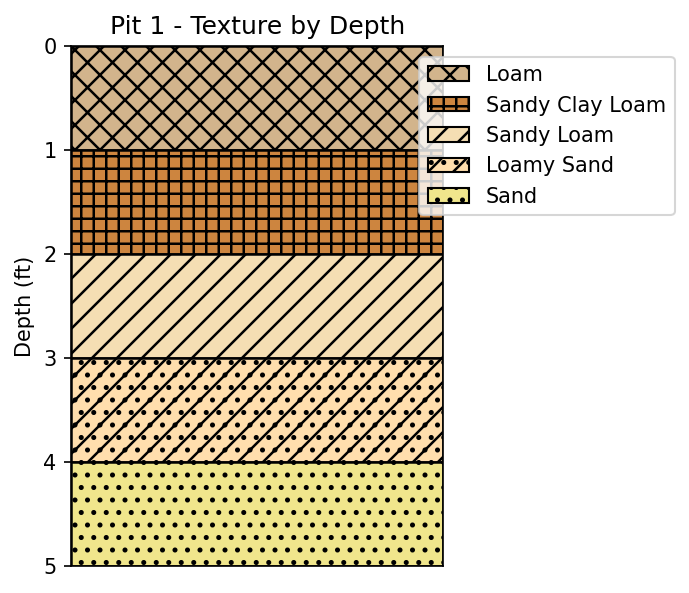

In [45]:
fig, ax = plot_texture_profile_df(
    df,
    depth_units=DEPTH_UNITS,
    fill_mode=FILL_MODE,
    png_dir=PNG_DIR,
    make_pngs_if_missing=MAKE_PNGS_IF_MISSING,
    figwidth_in=FIGWIDTH_IN,
    auto_figheight=AUTO_FIGHEIGHT,
    inches_per_100_cm=INCHES_PER_100_CM,
    inches_per_10_ft=INCHES_PER_10_FT,
    figheight_min_in=FIGHEIGHT_MIN_IN,
    figheight_max_in=FIGHEIGHT_MAX_IN,
    dpi=DPI,
    title=TITLE,
    label_layers=LABEL_LAYERS,
    legend=LEGEND,
)

plt.show()

if SAVE_FIG:
    fig.savefig(OUT_PNG, bbox_inches="tight", dpi=DPI)
    print(f"Saved figure to: {OUT_PNG}")
